Import the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

Import the dataset

Dataset Link: http://www.kaggle.com/datasets/akshatgupta7/crop-yield-in-indian-states-dataset

In [2]:
FILENAME = ''

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        FILENAME = os.path.join(dirname, filename)

In [3]:
dataset = pd.read_csv(FILENAME)

dataset.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [4]:
dataset.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


There are a total of 19689 entries

In [5]:
dataset['Crop'] = dataset['Crop'].str.strip()
dataset['Season'] = dataset['Season'].str.strip()
dataset['State'] = dataset['State'].str.strip()

Stripping the whitespace before and after all string data

In [6]:
print(f"Number of unique crops: {dataset['Crop'].nunique()}")
print(f"Number of unique seasons: {dataset['Season'].nunique()}")
print(f"Number of unique states: {dataset['State'].nunique()}")

Number of unique crops: 55
Number of unique seasons: 6
Number of unique states: 30


Plotting count of each crop, season, state

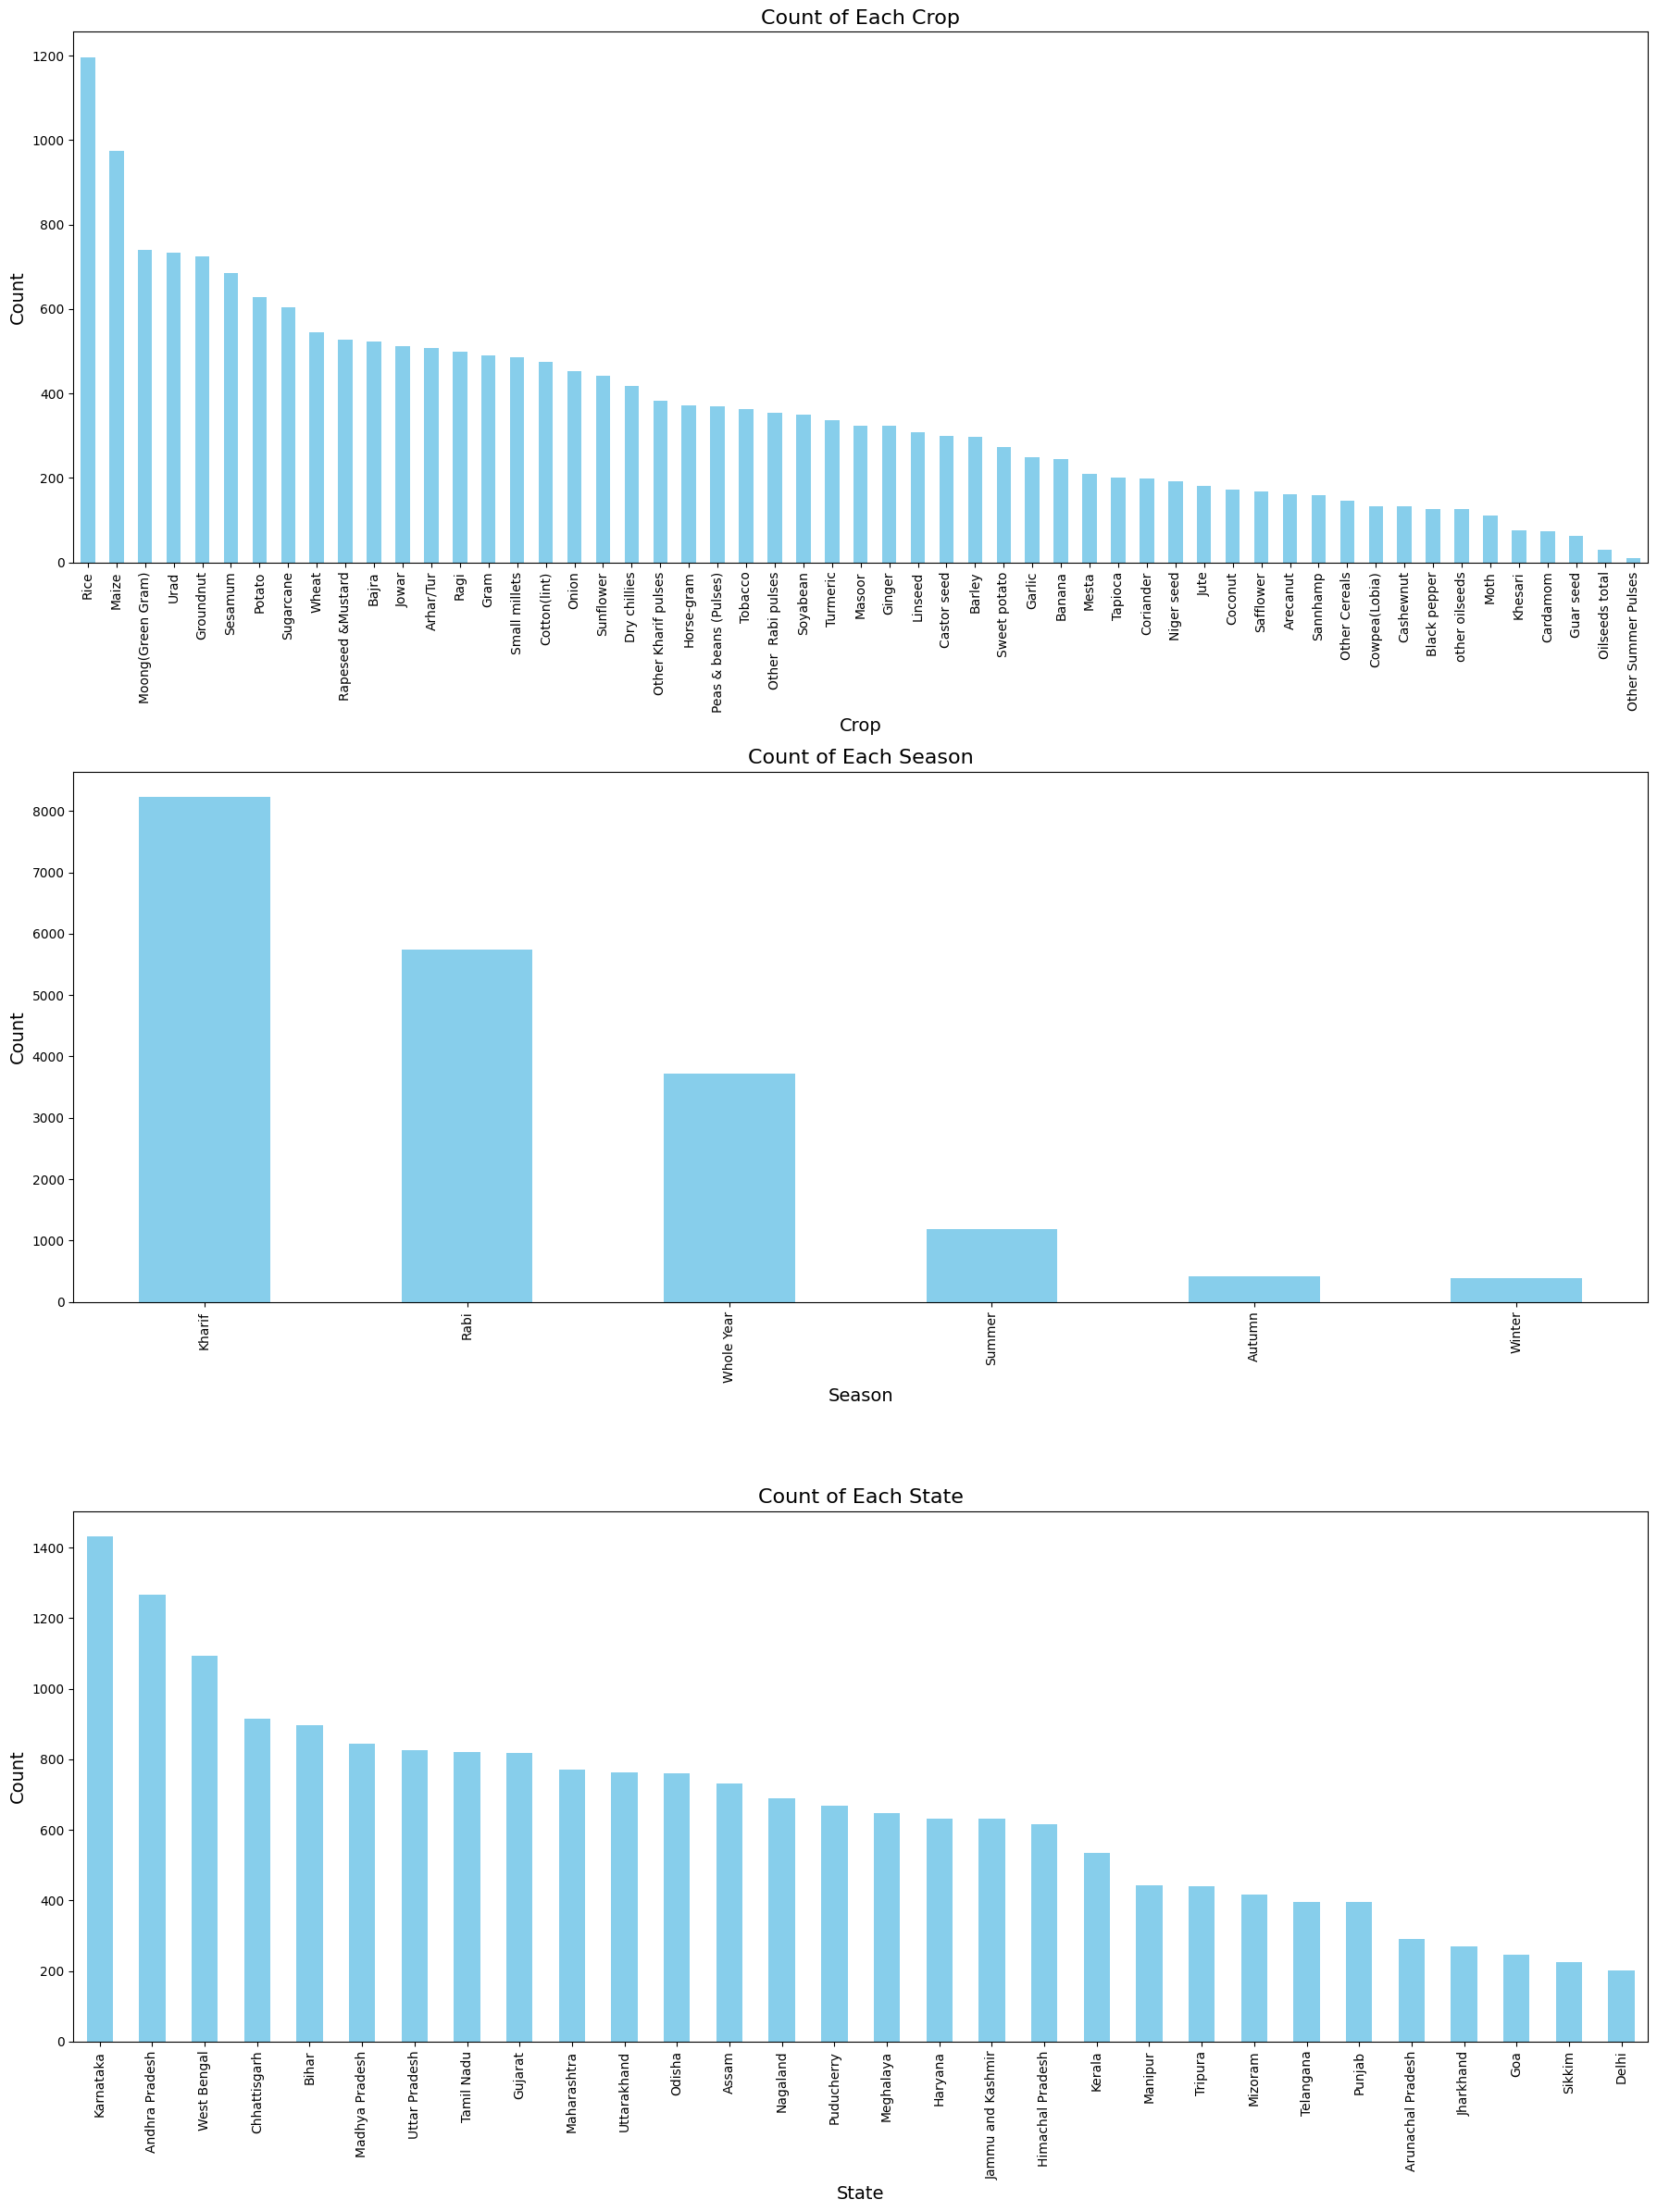

In [7]:
crop_counts = dataset['Crop'].value_counts()
season_counts = dataset['Season'].value_counts()
state_counts = dataset['State'].value_counts()

fig, axes = plt.subplots(3, 1, figsize=(18, 24))

crop_counts.plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_xlabel("Crop", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)
axes[0].set_title("Count of Each Crop", fontsize=16)
axes[0].tick_params(axis='x', rotation=90)

season_counts.plot(kind="bar", ax=axes[1], color="skyblue")
axes[1].set_xlabel("Season", fontsize=14)
axes[1].set_ylabel("Count", fontsize=14)
axes[1].set_title("Count of Each Season", fontsize=16)
axes[1].tick_params(axis='x', rotation=90)

state_counts.plot(kind="bar", ax=axes[2], color="skyblue")
axes[2].set_xlabel("State", fontsize=14)
axes[2].set_ylabel("Count", fontsize=14)
axes[2].set_title("Count of Each State", fontsize=16)
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

We segment the whole dataset into datasets corresponding to each crop

In [8]:
datasets = {}

for crop in dataset['Crop'].unique():
    datasets[crop] = dataset[dataset['Crop'] == crop]

In [9]:
wheat_dataset = datasets["Wheat"]

datasets['Wheat']['Season'].unique()

array(['Rabi', 'Whole Year', 'Kharif', 'Winter', 'Summer'], dtype=object)

Plotting the distribution of yield according to each season

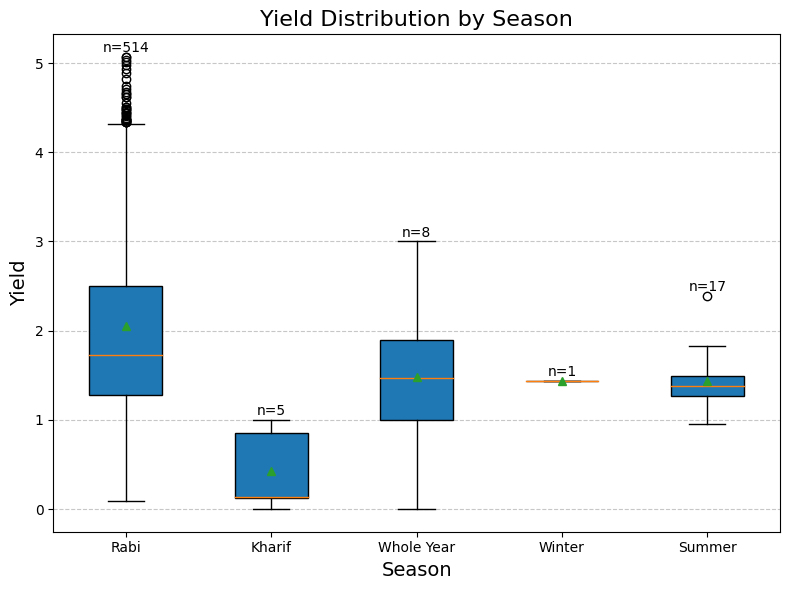

In [10]:
rabi_yield = wheat_dataset[wheat_dataset['Season'] == 'Rabi']['Yield']
kharif_yield = wheat_dataset[wheat_dataset['Season'] == 'Kharif']['Yield']
whole_year_yield = wheat_dataset[wheat_dataset['Season'] == 'Whole Year']['Yield']
winter_yield = wheat_dataset[wheat_dataset['Season'] == 'Winter']['Yield']
summer_yield = wheat_dataset[wheat_dataset['Season'] == 'Summer']['Yield']

data_to_plot = [rabi_yield, kharif_yield, whole_year_yield, winter_yield, summer_yield]
labels = ["Rabi", "Kharif", "Whole Year", "Winter", "Summer"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True)

ax.set_title("Yield Distribution by Season", fontsize=16)
ax.set_xlabel("Season", fontsize=14)
ax.set_ylabel("Yield", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, values in enumerate(data_to_plot):
    count = len(values)
    x_position = i + 1
    y_position = max(values) + 0.1
    ax.text(x_position, y_position, f"n={count}", ha="center", va="center", fontsize=10, color="black")

plt.tight_layout()
plt.show()

Calculating Correlations

In [11]:
z_scores = wheat_dataset.select_dtypes(include=[float, int]).apply(zscore)

threshold = 3
wheat_dataset = wheat_dataset[(z_scores.abs() < threshold).all(axis=1)]

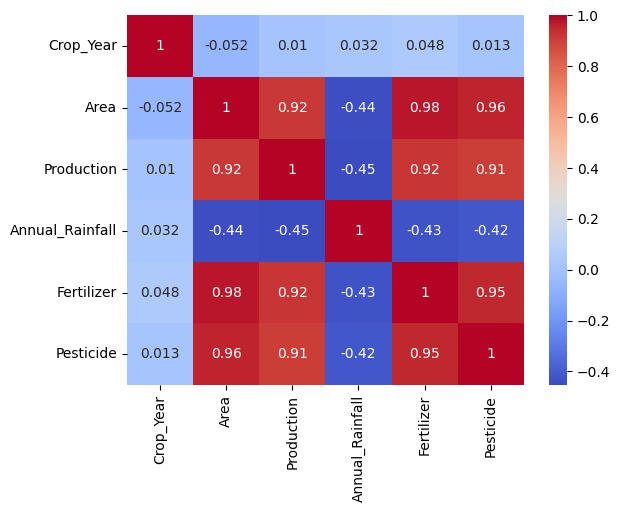

In [12]:
corr_matrix = wheat_dataset[["Crop_Year", "Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

As our data is variably scaled, we normalise it using standard scaler i.e. (x-u)/s

https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

In [13]:
columns_to_scale = ["Crop_Year", "Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]

scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(wheat_dataset[columns_to_scale])
scaled_df = pd.DataFrame(scaled_dataset, columns=columns_to_scale, index=wheat_dataset.index)

wheat_dataset.loc[:, columns_to_scale] = scaled_df

wheat_dataset.head()

/tmp/ipykernel_24/408089447.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.79546212 -1.79546212 -1.79546212 -1.79546212 -1.64156536 -1.64156536
 -1.64156536 -1.48766861 -1.48766861 -1.33377186 -1.33377186 -1.33377186
 -1.33377186 -1.1798751  -1.1798751  -1.1798751  -1.1798751  -1.02597835
 -1.02597835 -1.02597835 -0.8720816  -0.8720816  -0.8720816  -0.8720816
 -0.8720816  -0.71818485 -0.56428809 -0.56428809 -0.56428809 -0.56428809
 -0.56428809 -0.41039134 -0.41039134 -0.41039134 -0.41039134 -0.41039134
 -0.25649459 -0.25649459 -0.25649459 -0.10259784 -0.10259784 -0.10259784
 -0.10259784 -0.10259784  0.05129892  0.05129892  0.05129892  0.05129892
  0.20519567  0.20519567  0.20519567  0.20519567  0.35909242  0.35909242
  0.35909242  0.51298918  0.51298918  0.51298918  0.51298918  0.51298918
  0.66688593  0.66688593  0.66688593  0.66688593  0.82078268  0.82078268
  0.82078268  0.82078268  0.82078268  0.974679

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
26,Wheat,-1.795462,Rabi,Assam,-0.508196,-0.466273,0.867414,-0.510044,-0.469624,1.259524
56,Wheat,-1.795462,Rabi,Karnataka,-0.372018,-0.464313,-0.212705,-0.416701,-0.320895,0.548333
87,Wheat,-1.795462,Rabi,Meghalaya,-0.574161,-0.490181,3.299366,-0.555260,-0.541669,1.385000
129,Wheat,-1.795462,Rabi,West Bengal,-0.276302,-0.303945,0.594184,-0.351093,-0.216358,1.886667
173,Wheat,-1.641565,Rabi,Assam,-0.504182,-0.470803,1.284485,-0.505371,-0.470419,0.999545


Calculating correlations of scaled data

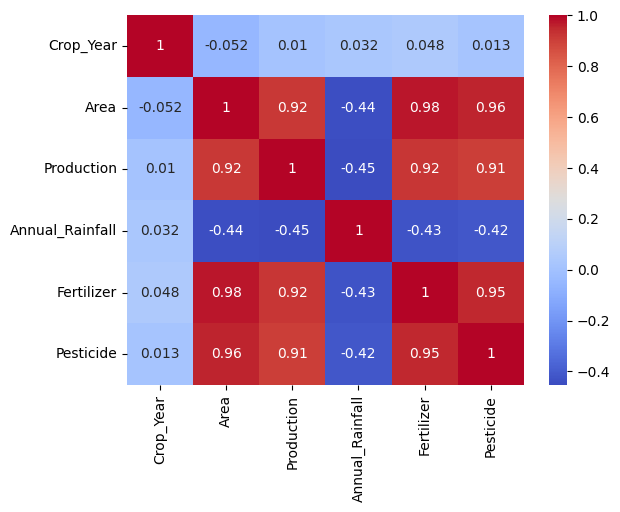

In [14]:
corr_matrix = wheat_dataset[columns_to_scale].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

Because there a string data for columns (Season, State), our model cannot process it.
So we converted string data to numerical by assigning different numerical values to each season in **Season** column and state in **State** column.

Label Encoder: https://scikit-learn.org/1.5/modules/preprocessing_targets.html#label-encoding

In [15]:
label_encoder = LabelEncoder()

wheat_dataset = wheat_dataset.copy()

wheat_dataset['Season_Encoded'] = label_encoder.fit_transform(wheat_dataset['Season'])
wheat_dataset['State_Encoded'] = label_encoder.fit_transform(wheat_dataset['State'])

In [16]:
wheat_dataset = wheat_dataset.drop(labels=['Season', 'State'], axis=1)

In [17]:
wheat_dataset.head()

,Crop,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield,Season_Encoded,State_Encoded
26,Wheat,-1.795462,-0.508196,-0.466273,0.867414,-0.510044,-0.469624,1.259524,1,2
56,Wheat,-1.795462,-0.372018,-0.464313,-0.212705,-0.416701,-0.320895,0.548333,1,11
87,Wheat,-1.795462,-0.574161,-0.490181,3.299366,-0.555260,-0.541669,1.385000,1,16
129,Wheat,-1.795462,-0.276302,-0.303945,0.594184,-0.351093,-0.216358,1.886667,1,25
173,Wheat,-1.641565,-0.504182,-0.470803,1.284485,-0.505371,-0.470419,0.999545,1,2


Splitting dataset into train and test (80% and 20%)

In [18]:
dataset = wheat_dataset.copy()

features = wheat_dataset[["Area", "Production", "Fertilizer", "Pesticide"]]

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

dataset = dataset.drop(columns=["Area", "Production", "Fertilizer", "Pesticide"])
dataset["PC1"] = pca_features[:, 0]
dataset["PC2"] = pca_features[:, 1]

dataset.head()

,Crop,Crop_Year,Annual_Rainfall,Yield,Season_Encoded,State_Encoded,PC1,PC2
26,Wheat,-1.795462,0.867414,1.259524,1,2,-0.977400,-0.012733
56,Wheat,-1.795462,-0.212705,0.548333,1,11,-0.786204,0.095240
87,Wheat,-1.795462,3.299366,1.385000,1,16,-1.081273,-0.045088
129,Wheat,-1.795462,0.594184,1.886667,1,25,-0.573858,0.032993
173,Wheat,-1.641565,1.284485,0.999545,1,2,-0.975635,-0.006879


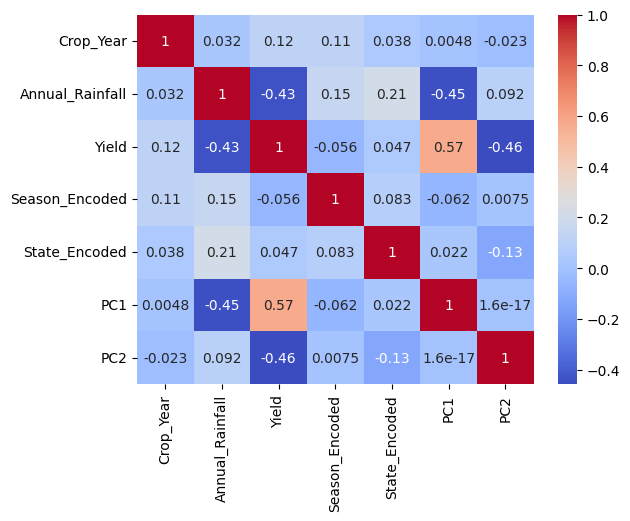

In [19]:
corr_matrix = dataset.drop(columns=["Crop"]).corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [20]:
X = dataset[['Crop_Year', 'Annual_Rainfall', "PC1", "PC2", 'Season_Encoded', 'State_Encoded']]
y = dataset['Yield']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [22]:
linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.5756
Mean Squared Error (MSE): 0.5444
R² Score: 0.4642


Using Linear Regression with L2 regularisation

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [23]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.5866
Mean Squared Error (MSE): 0.5538
R² Score: 0.4549


Using Decision Tree regressor

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [24]:
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.1286
Mean Absolute Error (MAE): 0.2320
R² Score: 0.8734


Using Random Forest ensemble regressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [25]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0785
Mean Absolute Error (MAE): 0.1838
R² Score: 0.9227


Using Gradient Boosted regressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [26]:
gradient_boost = GradientBoostingRegressor(random_state=42)
gradient_boost.fit(X_train, y_train)

y_pred = gradient_boost.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.1011
Mean Absolute Error (MAE): 0.2221
R² Score: 0.9005


Using Multi-Layer Perceptron regressor

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [27]:
mlp = MLPRegressor(random_state=42, max_iter=10000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.2883
Mean Absolute Error (MAE): 0.4130
R² Score: 0.7163
